In [1]:
import pandas as pd
import geopandas as gpd
import folium
from shapely import wkt
import os
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import variation
import numpy as np

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    gpu0 = gpus[0]
    tf.config.experimental.set_memory_growth(gpu0, True)
    tf.config.set_visible_devices([gpu0],"GPU")


In [3]:
from google.colab import drive
drive.mount('/content/drive/')
data_path=('/content/drive/MyDrive/CDS 529 Method/')

df = pd.read_csv(data_path + 'Dataset/Calculate_TPU_index.csv')
df= df[df['Simpson_Total'] >= 15]
df

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,tpuid,date,Simpson_Index,Simpson_Total,Evenness_Index,Entropy
0,111,2023-09-01 08:00:00,0.559118,165,0.669479,1.338957
1,111,2023-09-01 09:00:00,0.617646,195,0.787274,1.574547
2,111,2023-09-01 10:00:00,0.629341,201,0.808032,1.616064
3,111,2023-09-01 11:00:00,0.604155,190,0.758401,1.516802
4,111,2023-09-01 12:00:00,0.607813,227,0.770307,1.540614
...,...,...,...,...,...,...
68038,975,2023-09-15 03:00:00,0.068329,57,0.160499,0.254385
68039,975,2023-09-15 04:00:00,0.141687,53,0.282182,0.447247
68040,975,2023-09-15 05:00:00,0.116618,49,0.245122,0.388509
68041,975,2023-09-15 06:00:00,0.108224,53,0.230789,0.365792


In [4]:
# TPU 读取
gfs = []
for f in os.listdir(data_path+ '/tpu_data_geo/'):
    if 'shp' not in f:
        continue
    if '._' in f:
        continue
    ## GBK for encode Chinese
    shapefile = gpd.read_file( data_path + '/tpu_data_geo/%s' % f, encoding="GBK")
    tupid = f.split('_')[1].split('.')[0]
    shapefile['tpuid'] = tupid
    ## set crs
    shapefile.crs = 'EPSG:4326'
    gfs.append(shapefile)
gfs = gpd.GeoDataFrame(pd.concat(gfs))

## select two columns only
sel_cols = ['tpuid', 'geometry']
gfs_sel = gfs[sel_cols]


In [5]:
def split_times_and_calculate_means(df):
    # Ensure the 'date' column is of datetime type
    df['date'] = pd.to_datetime(df['date'])

    # Extract hour part
    df['hour'] = df['date'].dt.hour

    # Define time periods
    conditions = [
        (df['hour'] >= 1) & (df['hour'] < 5),  # Night
        (df['hour'] >= 5) & (df['hour'] < 10), # Morning
        (df['hour'] >= 10) & (df['hour'] < 15),# Noon
        (df['hour'] >= 15) & (df['hour'] < 20) # Evening
    ]
    choices = ['Night', 'Morning', 'Noon', 'Evening']
    df['time_period'] = pd.cut(df['hour'], bins=[1, 5, 10, 15, 20], labels=choices, right=False)

    # Initialize dictionary for time period DataFrames
    time_dfs = {}

    # Compute means for each time period
    for period in choices:
        time_df = df[df['time_period'] == period]
        grouped = time_df.groupby(['tpuid', time_df['date'].dt.date])['Simpson_Index'].mean().reset_index()
        grouped.rename(columns={'date': 'date_only', 'Simpson_Index': f'{period.lower()}_simpson_index'}, inplace=True)
        time_dfs[period] = grouped

    return time_dfs['Night'], time_dfs['Morning'], time_dfs['Noon'], time_dfs['Evening']

df_night, df_morning, df_noon, df_evening = split_times_and_calculate_means(df)

# 打印结果以验证
print("Night DataFrame:")
print(df_night)
print("\nMorning DataFrame:")
print(df_morning)
print("\nNoon DataFrame:")
print(df_noon)
print("\nEvening DataFrame:")
print(df_evening)


Night DataFrame:
     tpuid   date_only  night_simpson_index
0      111  2023-09-02             0.541977
1      111  2023-09-03             0.543233
2      111  2023-09-04             0.528317
3      111  2023-09-05             0.530890
4      111  2023-09-06             0.511964
...    ...         ...                  ...
1917   975  2023-09-11             0.091737
1918   975  2023-09-12             0.096328
1919   975  2023-09-13             0.128298
1920   975  2023-09-14             0.270016
1921   975  2023-09-15             0.105483

[1922 rows x 3 columns]

Morning DataFrame:
     tpuid   date_only  morning_simpson_index
0      111  2023-09-01               0.588382
1      111  2023-09-02               0.547918
2      111  2023-09-03               0.535420
3      111  2023-09-04               0.548224
4      111  2023-09-05               0.555037
...    ...         ...                    ...
2448   975  2023-09-11               0.216187
2449   975  2023-09-12               0.143

In [6]:
tpu_N_mean = df_night.groupby('tpuid')['night_simpson_index'].mean().reset_index()
tpu_M_mean = df_morning.groupby('tpuid')['morning_simpson_index'].mean().reset_index()
tpu_NOON_mean = df_noon.groupby('tpuid')['noon_simpson_index'].mean().reset_index()
tpu_E_mean = df_evening.groupby('tpuid')['evening_simpson_index'].mean().reset_index()
# 4表合并，与tpu结合

# Merging all mean dataframes
from functools import reduce

data_frames = [tpu_N_mean, tpu_M_mean, tpu_NOON_mean, tpu_E_mean]
tpu_mean = reduce(lambda left, right: pd.merge(left, right, on='tpuid', how='outer'), data_frames)

# Step 2: Merge the resulting tpu_mean dataframe with gfs_sel on 'tpuid'
final_df = pd.merge(tpu_mean, gfs_sel, on='tpuid', how='left')

# Now you can use final_df for further analysis or export
final_df


,tpuid,night_simpson_index,morning_simpson_index,noon_simpson_index,evening_simpson_index,geometry
0,111,0.538805,0.557318,0.599429,0.592413,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ..."
1,112,0.601223,0.632350,0.670145,0.658305,"POLYGON ((114.13725 22.28459, 114.13723 22.284..."
2,113,0.524133,0.576797,0.633772,0.624408,"POLYGON ((114.14963 22.28368, 114.14940 22.283..."
3,114,0.212765,0.542920,0.673972,0.666048,"POLYGON ((114.15307 22.28257, 114.15274 22.282..."
4,115,0.461967,0.578557,0.657254,0.655000,"POLYGON ((114.14818 22.28841, 114.14801 22.288..."
...,...,...,...,...,...,...
195,920,NaN,NaN,0.555530,0.545948,"POLYGON ((114.02832 22.20034, 114.02832 22.200..."
196,931S,NaN,NaN,0.632395,0.611234,"MULTIPOLYGON (((113.98763 22.20206, 113.98765 ..."
197,941S,NaN,NaN,0.639100,0.630594,"MULTIPOLYGON (((113.83562 22.21772, 113.83563 ..."
198,544,NaN,NaN,NaN,0.304688,"POLYGON ((114.05795 22.46155, 114.05794 22.461..."


In [7]:
def safe_divide(a, b):
    return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

final_df['morning_vs_night_change'] = safe_divide((final_df['morning_simpson_index'] - final_df['night_simpson_index']), final_df['night_simpson_index'])
final_df['noon_vs_night_change'] = safe_divide((final_df['noon_simpson_index'] - final_df['night_simpson_index']), final_df['night_simpson_index'])
final_df['evening_vs_night_change'] = safe_divide((final_df['evening_simpson_index'] - final_df['night_simpson_index']), final_df['night_simpson_index'])
final_df

,tpuid,night_simpson_index,morning_simpson_index,noon_simpson_index,evening_simpson_index,geometry,morning_vs_night_change,noon_vs_night_change,evening_vs_night_change
0,111,0.538805,0.557318,0.599429,0.592413,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",0.034360,0.112516,0.099495
1,112,0.601223,0.632350,0.670145,0.658305,"POLYGON ((114.13725 22.28459, 114.13723 22.284...",0.051772,0.114637,0.094943
2,113,0.524133,0.576797,0.633772,0.624408,"POLYGON ((114.14963 22.28368, 114.14940 22.283...",0.100478,0.209181,0.191315
3,114,0.212765,0.542920,0.673972,0.666048,"POLYGON ((114.15307 22.28257, 114.15274 22.282...",1.551729,2.167680,2.130435
4,115,0.461967,0.578557,0.657254,0.655000,"POLYGON ((114.14818 22.28841, 114.14801 22.288...",0.252376,0.422728,0.417849
...,...,...,...,...,...,...,...,...,...
195,920,NaN,NaN,0.555530,0.545948,"POLYGON ((114.02832 22.20034, 114.02832 22.200...",NaN,NaN,NaN
196,931S,NaN,NaN,0.632395,0.611234,"MULTIPOLYGON (((113.98763 22.20206, 113.98765 ...",NaN,NaN,NaN
197,941S,NaN,NaN,0.639100,0.630594,"MULTIPOLYGON (((113.83562 22.21772, 113.83563 ...",NaN,NaN,NaN
198,544,NaN,NaN,NaN,0.304688,"POLYGON ((114.05795 22.46155, 114.05794 22.461...",NaN,NaN,NaN


# 可视化

### 动态变化（早午晚夜）

In [8]:
df_morning = pd.merge(df_morning, gfs_sel, on='tpuid', how='left')
df_morning = gpd.GeoDataFrame(df_morning, geometry='geometry')
df_morning.crs = "EPSG:4326"
df_noon = pd.merge(df_noon, gfs_sel, on='tpuid', how='left')
df_noon = gpd.GeoDataFrame(df_noon, geometry='geometry')
df_noon.crs = "EPSG:4326"
df_evening = pd.merge(df_evening, gfs_sel, on='tpuid', how='left')
df_evening = gpd.GeoDataFrame(df_evening, geometry='geometry')
df_evening.crs = "EPSG:4326"

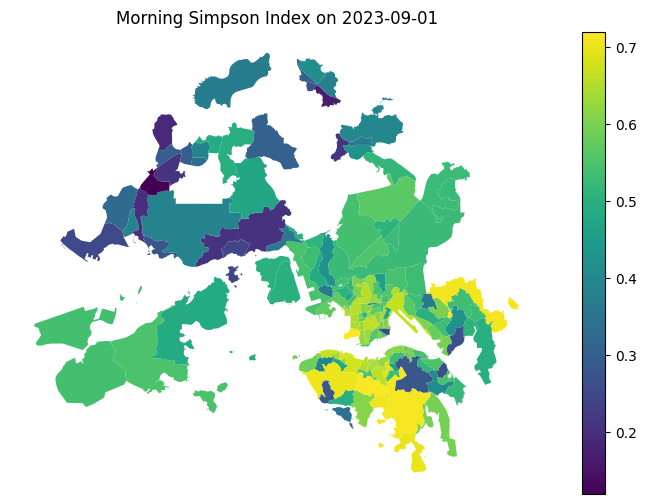

In [9]:
# 日期列是 datetime 对象
df_morning['date_only'] = pd.to_datetime(df_morning['date_only'])

# 将日期列转换为字符串，便于后续处理
df_morning['date_str'] = df_morning['date_only'].dt.strftime('%Y-%m-%d')

# 获取唯一的日期列表
unique_dates2 = df_morning['date_str'].unique()

# 创建图形和轴对象
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# 定义初始绘图函数，将初始图层绘制在轴上
def init2():
    df_morning[df_morning['date_str'] == unique_dates2[0]].plot(column='morning_simpson_index', ax=ax, legend=True, cmap='viridis')
    ax.set_title(f"Morning Simpson Index on {unique_dates2[0]}")
    ax.axis('off')

# 更新函数：每次被调用时，它会根据新的日期更新图层
def update2(date_str):
    ax.clear()
    df_morning[df_morning['date_str'] == date_str].plot(column='morning_simpson_index', ax=ax, legend=False, cmap='viridis')
    ax.set_title(f"Morning Simpson Index on {date_str}")
    ax.axis('off')

# 创建动画对象，这里每500毫秒更新一次
ani = FuncAnimation(fig, update2, init_func=init2, frames=unique_dates2, interval=500, repeat=False)

#HTML(ani.to_html5_video())

#ani.save(data_path+'morning_animation.gif', writer='pillow', fps=2)

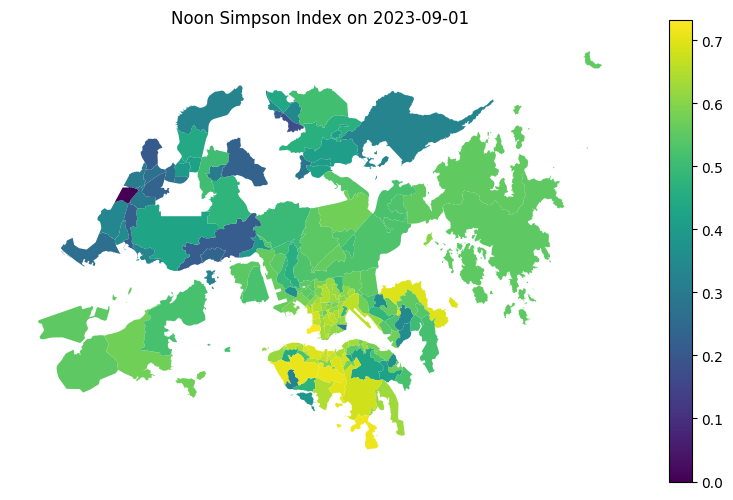

In [10]:
# 日期列是 datetime 对象
df_noon['date_only'] = pd.to_datetime(df_noon['date_only'])

# 将日期列转换为字符串，便于后续处理
df_noon['date_str'] = df_noon['date_only'].dt.strftime('%Y-%m-%d')

# 获取唯一的日期列表
unique_dates2 = df_noon['date_str'].unique()

# 创建图形和轴对象
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# 定义初始绘图函数，将初始图层绘制在轴上
def init2():
    df_noon[df_noon['date_str'] == unique_dates2[0]].plot(column='noon_simpson_index', ax=ax, legend=True, cmap='viridis')
    ax.set_title(f"Noon Simpson Index on {unique_dates2[0]}")
    ax.axis('off')

# 更新函数：每次被调用时，它会根据新的日期更新图层
def update2(date_str):
    ax.clear()
    df_noon[df_noon['date_str'] == date_str].plot(column='noon_simpson_index', ax=ax, legend=False, cmap='viridis')
    ax.set_title(f"Noon Simpson Index on {date_str}")
    ax.axis('off')

# 创建动画对象，这里每500毫秒更新一次
ani3 = FuncAnimation(fig, update2, init_func=init2, frames=unique_dates2, interval=500, repeat=False)

#HTML(ani3.to_html5_video())

#ani3.save(data_path+'noon_animation.gif', writer='pillow', fps=2)

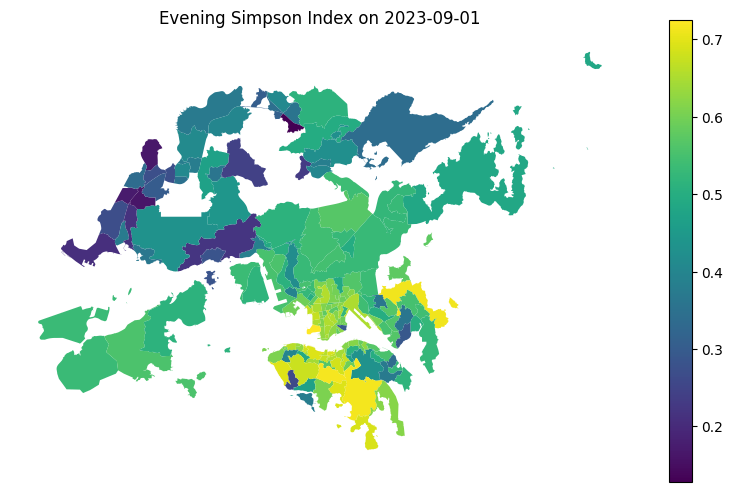

In [11]:
## 日期列是 datetime 对象
df_evening['date_only'] = pd.to_datetime(df_evening['date_only'])

# 将日期列转换为字符串，便于后续处理
df_evening['date_str'] = df_evening['date_only'].dt.strftime('%Y-%m-%d')

# 获取唯一的日期列表
unique_dates2 = df_evening['date_str'].unique()

# 创建图形和轴对象
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# 定义初始绘图函数，将初始图层绘制在轴上
def init2():
    df_evening[df_evening['date_str'] == unique_dates2[0]].plot(column='evening_simpson_index', ax=ax, legend=True, cmap='viridis')
    ax.set_title(f"Evening Simpson Index on {unique_dates2[0]}")
    ax.axis('off')

# 更新函数：每次被调用时，它会根据新的日期更新图层
def update2(date_str):
    ax.clear()
    df_evening[df_evening['date_str'] == date_str].plot(column='evening_simpson_index', ax=ax, legend=False, cmap='viridis')
    ax.set_title(f"Evening Simpson Index on {date_str}")
    ax.axis('off')

# 创建动画对象，这里每500毫秒更新一次
ani4 = FuncAnimation(fig, update2, init_func=init2, frames=unique_dates2, interval=500, repeat=False)
#播放
#HTML(ani4.to_html5_video())
#保存
#ani4.save(data_path+'evening_animation.gif', writer='pillow', fps=2)

In [12]:
df_night = pd.merge(df_night, gfs_sel, on='tpuid', how='left')
df_night = gpd.GeoDataFrame(df_night, geometry='geometry')
df_night.crs = "EPSG:4326"


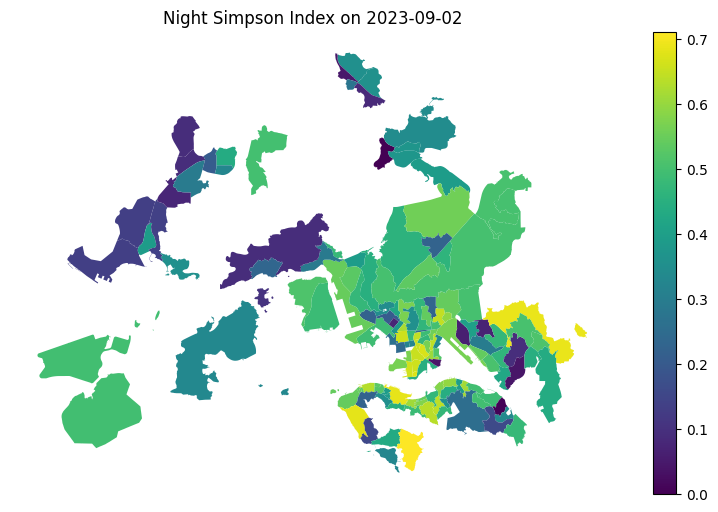

In [13]:
# 日期列是 datetime 对象
df_night['date_only'] = pd.to_datetime(df_night['date_only'])

# 将日期列转换为字符串，便于后续处理
df_night['date_str'] = df_night['date_only'].dt.strftime('%Y-%m-%d')

# 获取唯一的日期列表
unique_dates2 = df_night['date_str'].unique()

# 创建图形和轴对象
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# 定义初始绘图函数，将初始图层绘制在轴上
def init2():
    df_night[df_night['date_str'] == unique_dates2[0]].plot(column='night_simpson_index', ax=ax, legend=True, cmap='viridis')
    ax.set_title(f"Night Simpson Index on {unique_dates2[0]}")
    ax.axis('off')

# 更新函数：每次被调用时，它会根据新的日期更新图层
def update2(date_str):
    ax.clear()
    df_night[df_night['date_str'] == date_str].plot(column='night_simpson_index', ax=ax, legend=False, cmap='viridis')
    ax.set_title(f"Night Simpson Index on {date_str}")
    ax.axis('off')

# 创建动画对象，这里每500毫秒更新一次
ani2 = FuncAnimation(fig, update2, init_func=init2, frames=unique_dates2, interval=500, repeat=False)
#HTML(ani2.to_html5_video())
#ani2.save(data_path+'night_animation.gif', writer='pillow', fps=2)

## 动态变化指数

# TPU Cluster

In [14]:
pip install pandas tslearn

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset


df['date'] = pd.to_datetime(df['date'])

# 将数据按tpuid分组，并创建时间序列
time_series_data = []
tpuid_list = []
for tpuid, group in df.groupby('tpuid'):
    ts = group.sort_values('date')['Simpson_Index'].values
    if len(ts) > 0:  # 确保序列不为空
        time_series_data.append(ts)
        tpuid_list.append(tpuid)

# 转换为统一长度的时间序列数据集
time_series_data = to_time_series_dataset(time_series_data)

# 标准化时间序列
time_series_data = TimeSeriesScalerMeanVariance().fit_transform(time_series_data)

# 使用K-means进行聚类
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10, random_state=0)
labels = model.fit_predict(time_series_data)


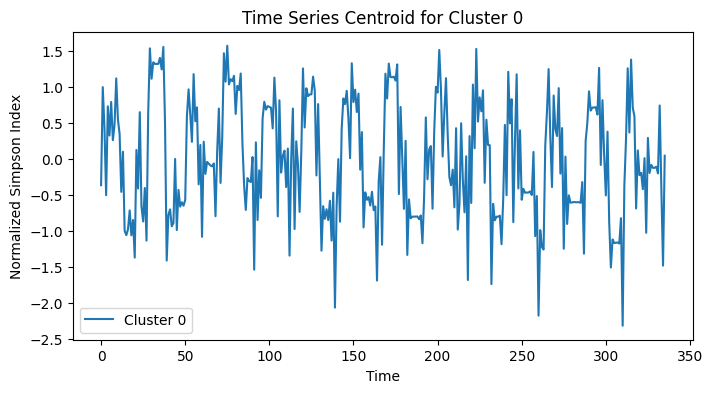

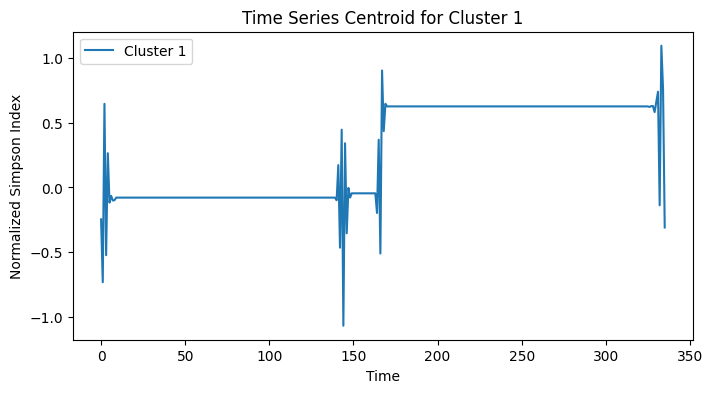

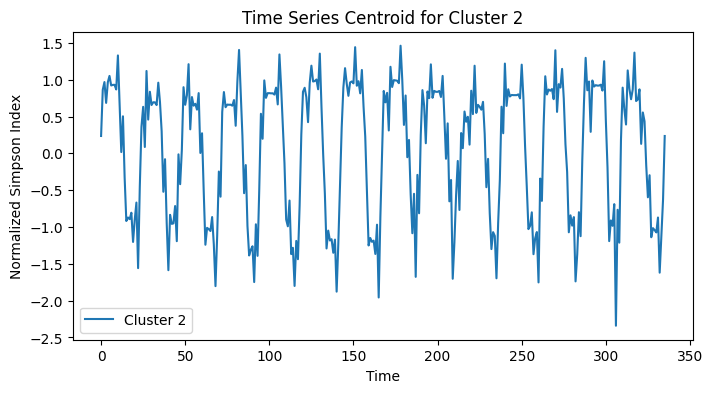

In [17]:
# 绘制每个聚类中心的时间序列
for i, centroid in enumerate(model.cluster_centers_):
    plt.figure(figsize=(8, 4))
    plt.plot(centroid.ravel(), label=f'Cluster {i}')
    plt.title(f'Time Series Centroid for Cluster {i}')
    plt.xlabel('Time')
    plt.ylabel('Normalized Simpson Index')
    plt.legend()
    plt.show()

In [18]:
cluster_df = pd.DataFrame({'tpuid': tpuid_list, 'Cluster': labels})
cluster_df = pd.merge(cluster_df, gfs_sel, on='tpuid', how='left')
cluster_df = gpd.GeoDataFrame(cluster_df, geometry='geometry')
cluster_df.crs = "EPSG:4326"
cluster_df

,tpuid,Cluster,geometry
0,111,2,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ..."
1,112,2,"POLYGON ((114.13725 22.28459, 114.13723 22.284..."
2,113,2,"POLYGON ((114.14963 22.28368, 114.14940 22.283..."
3,114,2,"POLYGON ((114.15307 22.28257, 114.15274 22.282..."
4,115,2,"POLYGON ((114.14818 22.28841, 114.14801 22.288..."
...,...,...,...
195,941S,1,"MULTIPOLYGON (((113.83562 22.21772, 113.83563 ..."
196,950S,2,"MULTIPOLYGON (((113.97876 22.32745, 113.97876 ..."
197,961S,0,"MULTIPOLYGON (((114.00320 22.26172, 114.00317 ..."
198,971S,2,"MULTIPOLYGON (((114.07899 22.28688, 114.07901 ..."


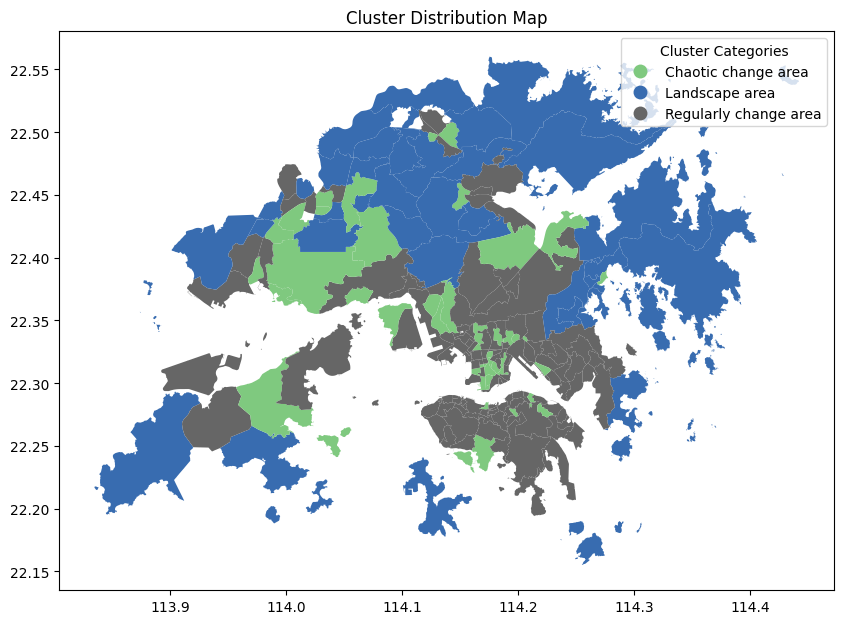

In [19]:
category_mapping = {
    0: "Chaotic change area",
    1: "Landscape area",
    2: "Regularly change area"
}

# 应用映射，创建一个新列用于显示
cluster_df['Category'] = cluster_df['Cluster'].replace(category_mapping)

# 创建画布和坐标系
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# 绘制地理数据，根据Category列进行分类显示
cluster_df.plot(column='Category', ax=ax, legend=True,
                cmap='Accent',  # 使用 viridis 颜色图
                categorical=True,  # 指定列为分类数据
                legend_kwds={'title': "Cluster Categories"})  # 设置图例标题

# 设置标题
plt.title('Cluster Distribution Map')

# 显示绘图
plt.show()

# 相关性分析

In [20]:
Tpu_df = pd.read_csv(data_path + 'Dataset/TPU.csv',encoding="utf-8")
# 将列名修改为"tpuid"
Tpu_df = Tpu_df.rename(columns={"小規劃統計區－小合併組": "tpuid"})

In [21]:
merged_df1 = cluster_df.merge(Tpu_df, on='tpuid')

merged_df1

,tpuid,Cluster,geometry,Category,Unnamed: 0,小規劃統計區－小合併組（英文名稱),小規劃統計區－小合併組（中文名稱),總人口,男性,女性,...,金融保险服务,体育休闲服务,科教文化服务,医疗保健服务,生活服务,餐饮服务,商务住宅,交通设施服务,购物服务,公司企业
0,111,2,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",Regularly change area,0,111,111,62272,28428,33844,...,2,18,8,13,29,55,34,36,46,79
1,112,2,"POLYGON ((114.13725 22.28459, 114.13723 22.284...",Regularly change area,1,112,112,51157,23911,27246,...,0,2,0,7,11,22,6,5,24,43
2,113,2,"POLYGON ((114.14963 22.28368, 114.14940 22.283...",Regularly change area,2,113,113,23043,10771,12272,...,43,26,31,162,121,201,102,47,402,980
3,114,2,"POLYGON ((114.15307 22.28257, 114.15274 22.282...",Regularly change area,3,114,114,8349,4056,4293,...,47,24,45,251,172,214,110,31,362,1726
4,115,2,"POLYGON ((114.14818 22.28841, 114.14801 22.288...",Regularly change area,4,115,115,1926,966,960,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,941S,1,"MULTIPOLYGON (((113.83562 22.21772, 113.83563 ...",Landscape area,207,941 - 943,941 - 943,1184,877,307,...,1,12,4,8,5,39,19,35,35,12
196,950S,2,"MULTIPOLYGON (((113.97876 22.32745, 113.97876 ...",Regularly change area,209,950 - 951,950 - 951,86403,40062,46341,...,24,20,38,52,56,192,61,139,213,62
197,961S,0,"MULTIPOLYGON (((114.00320 22.26172, 114.00317 ...",Chaotic change area,210,961 - 963,961 - 963,7403,3920,3483,...,1,15,12,6,12,43,20,20,34,19
198,971S,2,"MULTIPOLYGON (((114.07899 22.28688, 114.07901 ...",Regularly change area,211,971 - 974,971 - 974,20408,8978,11430,...,7,29,4,4,10,27,45,49,33,52


In [22]:
# 转换CRS到香港投影坐标系统，而不是之前4326的地理坐标系统
merged_df1 = merged_df1.to_crs(epsg=2326)
#计算面积，单位为平方米
merged_df1['area'] = merged_df1.area

# 计算人口密度（人/平方米）
merged_df1['population_density'] = merged_df1['總人口'] / merged_df1['area']
# 选择只包含数值类型数据的列

numeric_columns = merged_df1.select_dtypes(include=[np.number]).columns
subset_df = merged_df1[numeric_columns]

# 计算特征之间的相关性
correlation_matrix = subset_df.corr()

# 获取与"Simpson_Index"指标的相关性，并选择前十个特征
top_correlated_features = correlation_matrix['Cluster'].sort_values(ascending=False)[1:11]

print("Top 10 Features Correlated with Cluster:")
for feature, score in top_correlated_features.items():
    print(f"{feature}: {score:.2f}")

Top 10 Features Correlated with Cluster:
跨區工作（工作地點為香港島）: 0.25
於家中工作: 0.25
居於香港以外地方: 0.24
專上教育：學位課程: 0.23
雜項社會及個人服務: 0.23
count_on: 0.22
少於 6,000: 0.21
count_off: 0.20
65 及以上: 0.20
女性.3: 0.19


In [23]:
# 加入中文字体
!wget -O simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"


--2024-05-02 15:34:22--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 188.114.96.0, 188.114.97.0, 2a06:98c1:3120::, ...
Connecting to www.wfonts.com (www.wfonts.com)|188.114.96.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘simhei.ttf’

simhei.ttf          100%[===================>]   9.58M  7.63MB/s    in 1.3s    

2024-05-02 15:34:24 (7.63 MB/s) - ‘simhei.ttf’ saved [10050870/10050870]



In [24]:
import matplotlib
import matplotlib.font_manager as font_manager

matplotlib.font_manager.fontManager.addfont('simhei.ttf')
matplotlib.rc('font', family='SimHei')

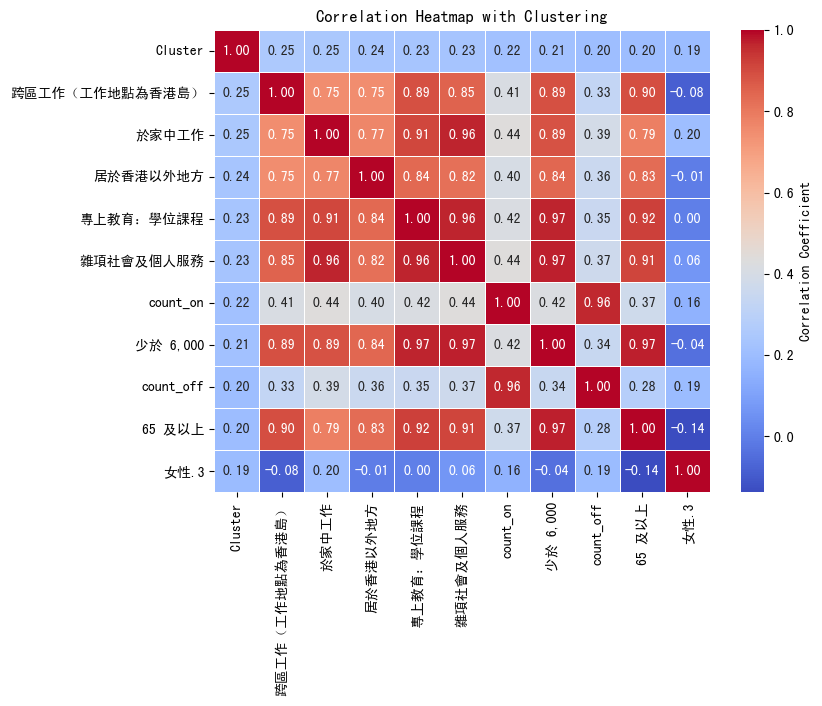

In [25]:
# 生成热力图的相关性子矩阵
top_features = ['Cluster'] + list(top_correlated_features.index)
correlation_submatrix = correlation_matrix.loc[top_features, top_features]

# 绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_submatrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap with Clustering')
plt.show()

# 早晚高峰变化相关性分析

In [26]:
merged_df2 = final_df.merge(Tpu_df, on='tpuid')

In [27]:
merged_df2= gpd.GeoDataFrame(merged_df2, geometry='geometry')
# 转换CRS到香港投影坐标系统，而不是之前4326的地理坐标系统
merged_df2 = merged_df2.to_crs(epsg=2326)
#计算面积，单位为平方米
merged_df2['area'] = merged_df2.area

# 计算人口密度（人/平方米）
merged_df2['population_density'] = merged_df2['總人口'] / merged_df2['area']
# 选择只包含数值类型数据的列


In [28]:
numeric_columns = merged_df2.select_dtypes(include=[np.number]).columns
subset_df = merged_df2[numeric_columns]

In [29]:
# 计算特征之间的相关性
correlation_matrix = subset_df.corr()

# 正确地从correlation_matrix中删除 'Unnamed: 0' 列
correlation_matrix = correlation_matrix.drop('Unnamed: 0', axis=1).drop('Unnamed: 0', axis=0)

# 获取与不同时间段变化指标的相关性，并选择前五个特征
top_correlated_features1 = correlation_matrix['morning_vs_night_change'].sort_values(ascending=False)[1:8]
top_correlated_features2 = correlation_matrix['noon_vs_night_change'].sort_values(ascending=False)[1:8]
top_correlated_features3 = correlation_matrix['evening_vs_night_change'].sort_values(ascending=False)[1:8]

# 打印相关性最高的五个特征
print("Top 5 Features Correlated with Morning vs Night Change:")
for feature, score in top_correlated_features1.items():
    print(f"{feature}: {score:.2f}")

print("\nTop 5 Features Correlated with Noon vs Night Change:")
for feature, score in top_correlated_features2.items():
    print(f"{feature}: {score:.2f}")

print("\nTop 5 Features Correlated with Evening vs Night Change:")
for feature, score in top_correlated_features3.items():
    print(f"{feature}: {score:.2f}")

Top 5 Features Correlated with Morning vs Night Change:
evening_vs_night_change: 0.98
noon_vs_night_change: 0.97
汽车销售: 0.25
女性.4: 0.17
能書寫中文的5歲及以上人口比例: 0.12
女性.1: 0.12
男女合計: 0.11

Top 5 Features Correlated with Noon vs Night Change:
evening_vs_night_change: 1.00
morning_vs_night_change: 0.97
汽车销售: 0.26
女性.4: 0.20
能書寫中文的5歲及以上人口比例: 0.15
能閱讀中文的5歲及以上人口比例: 0.13
女性.1: 0.10

Top 5 Features Correlated with Evening vs Night Change:
noon_vs_night_change: 1.00
morning_vs_night_change: 0.98
汽车销售: 0.26
女性.4: 0.19
能書寫中文的5歲及以上人口比例: 0.14
能閱讀中文的5歲及以上人口比例: 0.12
女性.1: 0.11


In [30]:
df_night

,tpuid,date_only,night_simpson_index,geometry,date_str
0,111,2023-09-02,0.541977,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",2023-09-02
1,111,2023-09-03,0.543233,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",2023-09-03
2,111,2023-09-04,0.528317,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",2023-09-04
3,111,2023-09-05,0.530890,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",2023-09-05
4,111,2023-09-06,0.511964,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",2023-09-06
...,...,...,...,...,...
1917,975,2023-09-11,0.091737,"MULTIPOLYGON (((114.06239 22.34132, 114.06240 ...",2023-09-11
1918,975,2023-09-12,0.096328,"MULTIPOLYGON (((114.06239 22.34132, 114.06240 ...",2023-09-12
1919,975,2023-09-13,0.128298,"MULTIPOLYGON (((114.06239 22.34132, 114.06240 ...",2023-09-13
1920,975,2023-09-14,0.270016,"MULTIPOLYGON (((114.06239 22.34132, 114.06240 ...",2023-09-14


# 热点分析


In [33]:
!pip install mapclassify

In [36]:
!pip install esda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 22.1 MB/s eta 0:00:00


<ipython-input-80-24c75ade0acd>:6: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = lps.weights.Queen.from_dataframe(df_night)
/usr/local/lib/python3.10/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)
<ipython-input-80-24c75ade0acd>:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


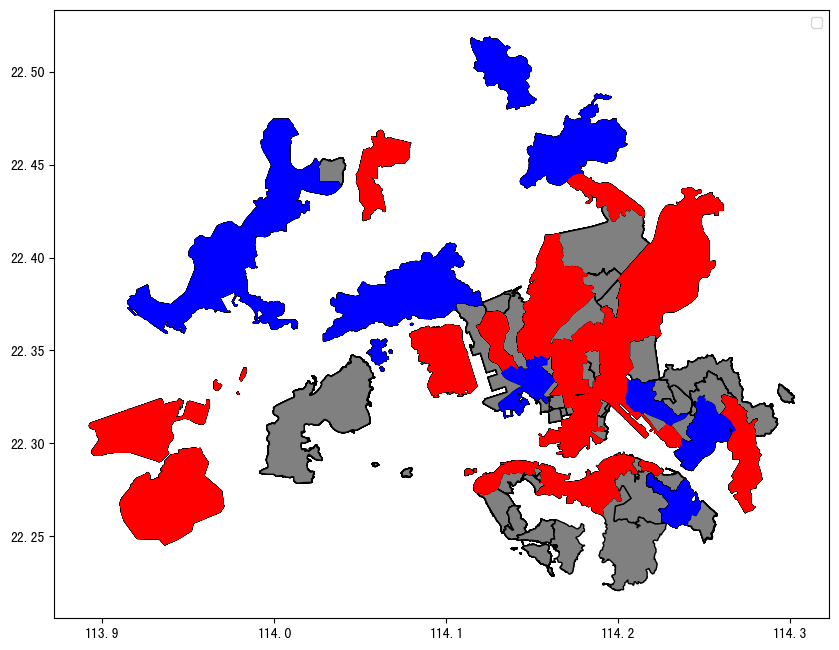

In [80]:
import geopandas as gpd
from esda.moran import Moran_Local
import libpysal as lps
import matplotlib.pyplot as plt

weights = lps.weights.Queen.from_dataframe(df_night)
weights.transform = 'R'  # 转换为行标准化格式

# 计算Moran's Local统计量
local_moran = Moran_Local(df_night['night_simpson_index'], weights)

# 将Moran结果添加到GeoDataFrame
df_night['moran_I'] = local_moran.Is
df_night['p_value'] = local_moran.p_sim

# 筛选显著的热点和冷点
hotspots = df_night[(local_moran.q == 1) & (local_moran.p_sim < 0.05)]
coldspots = df_night[(local_moran.q == 3) & (local_moran.p_sim < 0.05)]

# 可视化结果
fig, ax = plt.subplots(figsize=(10, 10))
df_night.plot(ax=ax, color='grey', edgecolor='black')
hotspots.plot(ax=ax, color='red', label='Hotspots')
coldspots.plot(ax=ax, color='blue', label='Coldspots')
plt.legend()
plt.show()

<ipython-input-81-6816a31cd89a>:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = lps.weights.Queen.from_dataframe(df_morning)
/usr/local/lib/python3.10/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)
<ipython-input-81-6816a31cd89a>:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


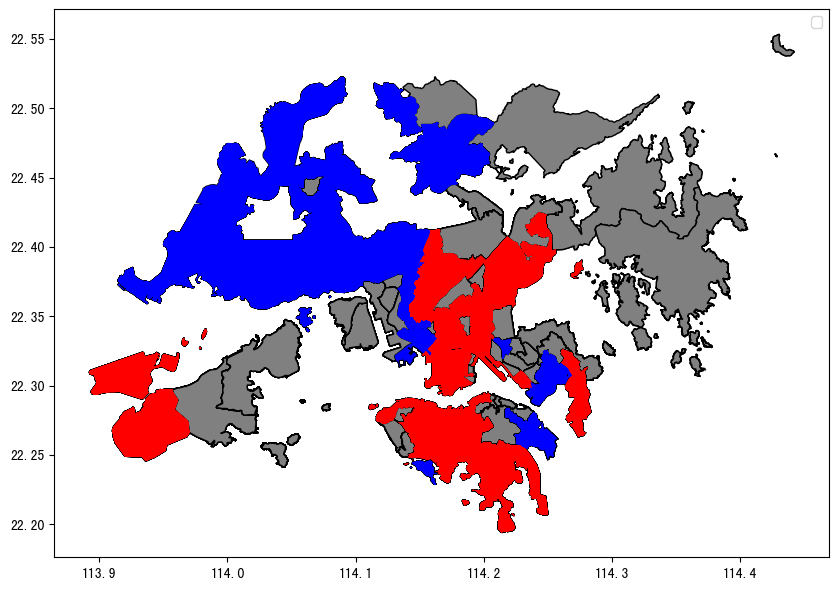

In [81]:

weights = lps.weights.Queen.from_dataframe(df_morning)
weights.transform = 'R'  # 转换为行标准化格式

# 计算Moran's Local统计量
local_moran = Moran_Local(df_morning['morning_simpson_index'], weights)

# 将Moran结果添加到GeoDataFrame
df_morning['moran_I'] = local_moran.Is
df_morning['p_value'] = local_moran.p_sim

# 筛选显著的热点和冷点
hotspots = df_morning[(local_moran.q == 1) & (local_moran.p_sim < 0.05)]
coldspots = df_morning[(local_moran.q == 3) & (local_moran.p_sim < 0.05)]

# 可视化结果
fig, ax = plt.subplots(figsize=(10, 10))
df_morning.plot(ax=ax, color='grey', edgecolor='black')
hotspots.plot(ax=ax, color='red', label='Hotspots')
coldspots.plot(ax=ax, color='blue', label='Coldspots')
plt.legend()
plt.show()

<ipython-input-82-bb82d4bcade1>:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = lps.weights.Queen.from_dataframe(df_noon)
/usr/local/lib/python3.10/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)
<ipython-input-82-bb82d4bcade1>:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


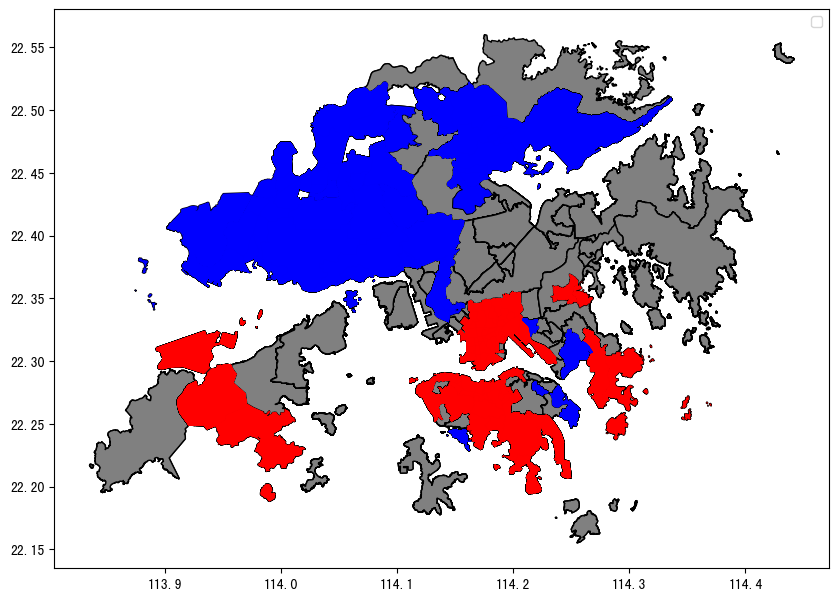

In [82]:

weights = lps.weights.Queen.from_dataframe(df_noon)
weights.transform = 'R'  # 转换为行标准化格式

# 计算Moran's Local统计量
local_moran = Moran_Local(df_noon['noon_simpson_index'], weights)

# 将Moran结果添加到GeoDataFrame
df_noon['moran_I'] = local_moran.Is
df_noon['p_value'] = local_moran.p_sim

# 筛选显著的热点和冷点
hotspots = df_noon[(local_moran.q == 1) & (local_moran.p_sim < 0.05)]
coldspots = df_noon[(local_moran.q == 3) & (local_moran.p_sim < 0.05)]

# 可视化结果
fig, ax = plt.subplots(figsize=(10, 10))
df_noon.plot(ax=ax, color='grey', edgecolor='black')
hotspots.plot(ax=ax, color='red', label='Hotspots')
coldspots.plot(ax=ax, color='blue', label='Coldspots')
plt.legend()
plt.show()

<ipython-input-83-54af55cb6681>:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = lps.weights.Queen.from_dataframe(df_evening)
/usr/local/lib/python3.10/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)
<ipython-input-83-54af55cb6681>:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


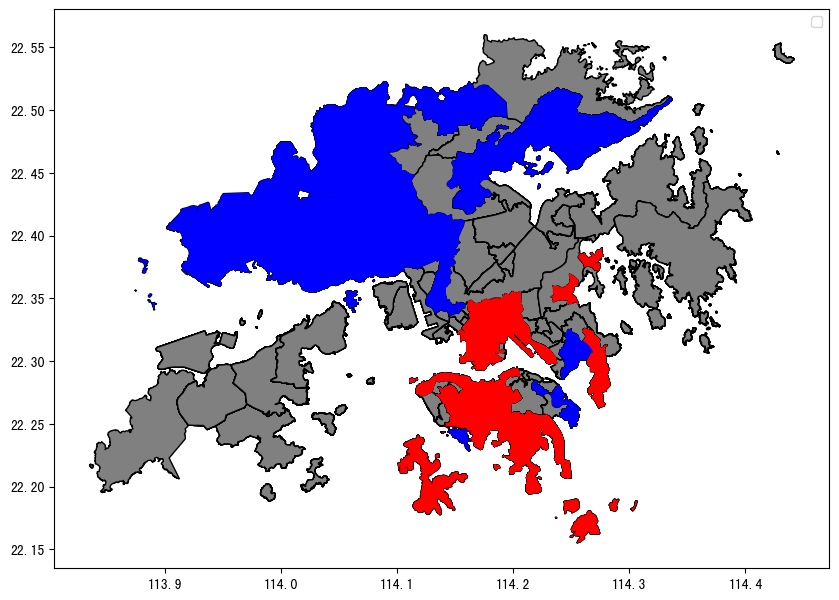

In [83]:

weights = lps.weights.Queen.from_dataframe(df_evening)
weights.transform = 'R'  # 转换为行标准化格式

# 计算Moran's Local统计量
local_moran = Moran_Local(df_evening['evening_simpson_index'], weights)

# 将Moran结果添加到GeoDataFrame
df_evening['moran_I'] = local_moran.Is
df_evening['p_value'] = local_moran.p_sim

# 筛选显著的热点和冷点
hotspots = df_evening[(local_moran.q == 1) & (local_moran.p_sim < 0.05)]
coldspots = df_evening[(local_moran.q == 3) & (local_moran.p_sim < 0.05)]

# 可视化结果
fig, ax = plt.subplots(figsize=(10, 10))
df_evening.plot(ax=ax, color='grey', edgecolor='black')
hotspots.plot(ax=ax, color='red', label='Hotspots')
coldspots.plot(ax=ax, color='blue', label='Coldspots')
plt.legend()
plt.show()